In [167]:
%run function_dbs.py
%run MLRegression_dbs.py

fs = 12
pd.set_option("display.precision", 3)

## Load data and split into training and validation data for pH and O2

In [58]:
# load data set for pH and O2
ddata_ph = pd.read_csv('460nm/20220921_trainingData-pH_balanced_absoluteInt.csv', sep='\t', index_col=0).astype(float)
ddata_ph.columns = [float(i) for i in ddata_ph.columns[:-1]] + ['O2 (%O2)']

ddata_ox = pd.read_csv('460nm/20220825_trainingData-O2_balanced_absoluteInt.csv', sep='\t', index_col=0).astype(float)
ddata_ox.columns = [float(i) for i in ddata_ox.columns[:-1]] + ['pH']

# -----------------------------------------------------------------------------------------
# split into training (80%) and validation (20%) data set
X_train_ph, X_valid_ph, truth_train_ph, truth_valid_ph = train_test_split(ddata_ph, ddata_ph.index, test_size=0.2, random_state=42)
X_train_ox, X_valid_ox, truth_train_ox, truth_valid_ox = train_test_split(ddata_ox, ddata_ox.index, test_size=0.2, random_state=42)

X_valid = pd.concat([pd.DataFrame(X_valid_ox.index, columns=['O2 (%O2)'], index=X_valid_ox.index),
                     pd.DataFrame(X_valid_ox['pH'], columns=['pH'], index=X_valid_ox.index), X_valid_ox.loc[:, 470:900]], axis=1)

y_valid_ox, y_valid_ph = X_valid['O2 (%O2)'].to_numpy(), X_valid['pH'].to_numpy()

# -----------------------------------------------------------------------------------------
# determined optimized hyperparameter for XGBoost 
dpara = dict({'pH': dict({'n_estimators': 100, 'min_child_weight': 15, 'max_depth': 13, 'learning_rate': 0.05}),
              'O2': dict({'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1})})

## Preparation of training data set for multilayered ML model

##### 1st Layer: pH prediction

In [54]:
# define training and validation set
X_train_l1 = X_train_ph.loc[:, 470:900]
X_train_l1 = X_train_l1.astype(float)
y_target_l1 = X_train_l1.index           # known pH

X_sample_l1 = X_valid.loc[:, 470:900] 
y_valid_l1 = y_valid_ph                  # known pH

print('training pH - 1st layer:', X_train_l1.shape, 'sample', X_sample_l1.shape)

# --------------------------------------------------------------------------------
# create the ML pipeline
reg_xgb_l1 = make_pipeline(preprocessing.StandardScaler(), 
                           xgb.XGBRegressor(n_estimators=dpara['pH']['n_estimators'], max_depth=dpara['pH']['max_depth'],
                                            min_child_weight=dpara['pH']['min_child_weight'], n_jobs=-1, random_state=42, 
                                            learning_rate=dpara['pH']['learning_rate']))

# execute the ML algorithm
[model_l1, y_predT_l1, y_pred_l1, paraT_l1,
 para_l1] = _fitPredict_experiement(model=reg_xgb_l1, X_train=np.array(X_train_l1), truth_train=y_target_l1, X_valid=X_sample_l1, 
                                    truth_sample=y_valid_l1)

# adjust precision of pH
y_predT_l1, y_pred_l1 = [round(i, 1) for i in y_predT_l1], [round(i, 1) for i in y_pred_l1]

training pH - 1st layer: (4136, 150) sample (502, 150)


##### 2nd Layer: O2 prediction with known pH

In [55]:
# define training and validation set
X_train_l2 = X_train_ox.astype(float)
y_target_l2 = X_train_l2.index        # known O2

X_sample_l2 = pd.concat([pd.DataFrame(y_pred_l1, index=X_sample_l1.index, columns=['pH']), X_valid.loc[:, 470:900]], axis=1)
y_valid_l2 = X_sample_l2.index       # known O2

print('training pH - 2nd layer:', X_train_l2.shape, 'sample', X_sample_l2.shape)

# convert columns to not raise any warnings - label pH as 1
X_sample_l2.columns = [1] + list(X_sample_l2.columns[1:])
X_train_l2.columns = list(X_train_l2.columns[:-1]) + [1] 

# --------------------------------------------------------------------------------
# create the ML pipeline
reg_xgb_l2 = make_pipeline(preprocessing.StandardScaler(), 
                           xgb.XGBRegressor(n_estimators=dpara['O2']['n_estimators'], max_depth=dpara['O2']['max_depth'], 
                                            learning_rate=dpara['O2']['learning_rate'], random_state=42, n_jobs=-1, 
                                            min_child_weight=dpara['O2']['min_child_weight']))

# execute ML algorithm
[model_l2, y_predT_l2, y_pred_l2, paraT_l2,
 para_l2] = _fitPredict_experiement(model=reg_xgb_l2, X_train=X_train_l2, truth_train=y_target_l2, X_valid=X_sample_l2, 
                                      truth_sample=y_valid_l2)

# reconvert the columns to the original parameter
X_train_l2.columns = list(X_train_l2.columns[:-1]) + ['pH']
X_sample_l2.columns = ['pH'] + list(X_sample_l2.columns[1:])

training pH - 2nd layer: (2004, 151) sample (502, 151)


##### 3rd Layer: O2 prediction iteration  with known pH and O2

In [56]:
X_train_l3 = pd.concat([pd.DataFrame(X_train_ph['O2 (%O2)'], index=X_train_ph.index, columns=['O2 (%O2)']),
                        pd.DataFrame(X_train_ph.index, index=X_train_ph.index, columns=['pH']),  
                        X_train_ph.loc[:, 470:900]], axis=1)
y_target_l3 = X_train_l3['O2 (%O2)'].to_numpy()

# built up your third layer with additional information about O2 (from first step regression) 
X_sample_l3 = pd.concat([pd.DataFrame(X_sample_l2.index, index=X_sample_l2.index, columns=['O2 (%O2)']), X_sample_l2], axis=1)
y_valid_l3 = X_sample_l3.index

print('training pH - 3rd layer:', X_train_l3.shape, 'sample', X_sample_l3.shape)

# convert columns to not raise any warnings
X_sample_l3.columns = [1, 2] + list(X_sample_l3.columns[2:])
X_train_l3.columns = [1, 2] + list(X_train_l3.columns[2:])

# --------------------------------------------------------------------------------
# execute ML algorithm
[model_l3, y_predT_l3, y_pred_l3, paraT_l3,
 para_l3] = _fitPredict_experiement(model=reg_xgb_l2, X_train=X_train_l3, truth_train=y_target_l3, X_valid=X_sample_l3, 
                                    truth_sample=y_valid_l3)

# reconvert the columns to the original parameter
X_train_l3.columns = ['O2 (%O2)', 'pH'] + list(X_train_l3.columns[2:])
X_sample_l3.columns = ['O2 (%O2)', 'pH'] + list(X_sample_l3.columns[2:])

# adjust precision of O2 
y_predT_l3, y_pred_l3 = [round(i, 2) for i in y_predT_l3], [round(i, 2) for i in y_pred_l3]

training pH - 3rd layer: (4136, 152) sample (502, 152)


/Users/au652733/Python/Project_pH+O2/MLRegression_dbs.py:255: RuntimeWarning: divide by zero encountered in true_divide
  z = (y_pred - y_true) / y_true


### Combine results for validation

In [178]:
# pH prediction
df_pred_Tph = pd.DataFrame(y_predT_l1, columns=['training pH - predict'])
df_pred_ph = pd.DataFrame(y_pred_l1, columns=['validation pH - predict'])
df_truth_Tph = pd.DataFrame(y_target_l1, columns=['validation pH - truth'])
df_truth_ph = pd.DataFrame(y_valid_l1, columns=['validation pH - truth'])

# O2 prediction
df_pred_Tox = pd.DataFrame(y_predT_l3, columns=['training O2 - predict'])
df_pred_ox = pd.DataFrame(y_pred_l3, columns=['validation O2 - predict'])
df_truth_Tox = pd.DataFrame(y_target_l3, columns=['validation O2 - truth'])
df_truth_ox = pd.DataFrame(y_valid_l3, columns=['validation O2 - truth'])

df_ph_train, df_ph_valid = pd.concat([df_pred_Tph, df_truth_Tph], axis=1), pd.concat([df_pred_ph, df_truth_ph], axis=1)
df_ox_train, df_ox_valid = pd.concat([df_pred_Tox, df_truth_Tox], axis=1), pd.concat([df_pred_ox, df_truth_ox], axis=1)

In [180]:
# mean and std for pH and O2 prediction of training and validation data
mean_Tph = np.nanmean(df_ph_train["training pH - predict"].subtract(df_ph_train["validation pH - truth"]))
std_Tph = np.nanstd(df_ph_train["training pH - predict"].subtract(df_ph_train["validation pH - truth"]))

mean_ph = np.nanmedian(df_ph_valid["validation pH - predict"].subtract(df_ph_valid["validation pH - truth"]))
std_ph = np.nanstd(df_ph_valid["validation pH - predict"].subtract(df_ph_valid["validation pH - truth"]))

mean_Tox = np.nanmean(df_ox_train["training O2 - predict"].subtract(df_ox_train["validation O2 - truth"]))
std_Tox = np.nanstd(df_ox_train["training O2 - predict"].subtract(df_ox_train["validation O2 - truth"]))

mean_ox = np.nanmedian(df_ox_valid["validation O2 - predict"].subtract(df_ox_valid["validation O2 - truth"]))
std_ox = np.nanstd(df_ox_valid["validation O2 - predict"].subtract(df_ox_valid["validation O2 - truth"]))

df_ph_train = df_ph_train.set_index('validation pH - truth')
df_ph_valid = df_ph_valid.set_index('validation pH - truth')
df_ox_train = df_ox_train.set_index('validation O2 - truth')
df_ox_valid = df_ox_valid.set_index('validation O2 - truth')
# ---------------------------------------------------------------------------------------------
print('Results for the sample data \n')
print('overall accuracy of pH value:')
print('\t training: \t {:.1f} +/- {:.2f}'.format(mean_Tph, std_Tph))
print('\t validation: \t {:.1f} +/- {:.2f}'.format(mean_ph, std_ph))

print('overall accuracy of O2 concentration:')
print('\t training: \t {:.1f} +/- {:.2f}'.format(mean_Tox, std_Tox))
print('\t validation: \t {:.1f} +/- {:.2f}'.format(mean_ox, std_ox))

Results for the sample data 

overall accuracy of pH value:
	 training: 	 -0.0 +/- 0.14
	 validation: 	 0.0 +/- 0.31
overall accuracy of O2 concentration:
	 training: 	 -0.0 +/- 0.00
	 validation: 	 0.0 +/- 0.19


cross-check of pH

<ipython-input-228-9713171c8e41>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  sns.despine(), plt.tight_layout()


(None, None)

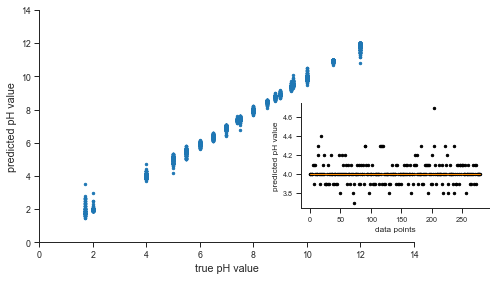

In [228]:
pH_insert = 4
fig, ax = plt.subplots(figsize=(6,4))
ax2 = plt.axes([0, 0, 1, 1])

ax.set_xlabel('true pH value', fontsize=fs*0.9), ax.set_ylabel('predicted pH value', fontsize=fs*0.9)
ax2.set_xlabel('data points', fontsize=fs*0.7), ax2.set_ylabel('predicted pH value', fontsize=fs*0.7)
ax2.tick_params(labelsize=fs*0.6)

ax.plot(df_ph_train, lw=0, marker='.')
ax.set_xlim(0, 14), ax.set_ylim(0, 14)

# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.7,0.15,0.5,0.45])
ax2.set_axes_locator(ip)
ax2.plot(df_ph_train.loc[pH_insert, 'training pH - predict'].to_numpy(), lw=0, marker='.', color='k')
ax2.plot(df_ph_train.loc[pH_insert].index, lw=1, color='darkorange')

sns.despine(), plt.tight_layout()

# ---------------------------------------------------------------------
# save figure
# fig.savefig('20221005_crossCheck_pH_training.svg', dpi=300, transparent=True)

<ipython-input-231-0457da82b60f>:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  sns.despine(), plt.tight_layout()


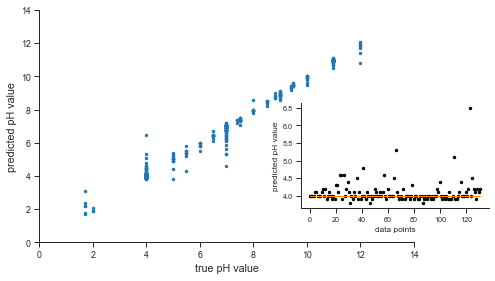

In [231]:
pH_insert = 4
fig, ax = plt.subplots(figsize=(6,4))
ax2 = plt.axes([0, 0, 1, 1])

ax.set_xlabel('true pH value', fontsize=fs*0.9), ax.set_ylabel('predicted pH value', fontsize=fs*0.9)
ax2.set_xlabel('data points', fontsize=fs*0.7), ax2.set_ylabel('predicted pH value', fontsize=fs*0.7)
ax2.tick_params(labelsize=fs*0.6)

ax.plot(df_ph_valid, lw=0, marker='.')
ax.set_xlim(0, 14), ax.set_ylim(0, 14)

# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.7,0.15,0.5,0.45])
ax2.set_axes_locator(ip)
ax2.plot(df_ph_valid.loc[pH_insert, 'validation pH - predict'].to_numpy(), lw=0, marker='.', color='k')
ax2.plot(df_ph_valid.loc[pH_insert].index, lw=1, color='darkorange')

sns.despine(), plt.tight_layout()

# ---------------------------------------------------------------------
# save figure
# fig.savefig('20221005_crossCheck_pH_validation.png', dpi=300, transparent=True)

cross-check of O2

<ipython-input-239-8da6e0f840a5>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  sns.despine(), plt.tight_layout()


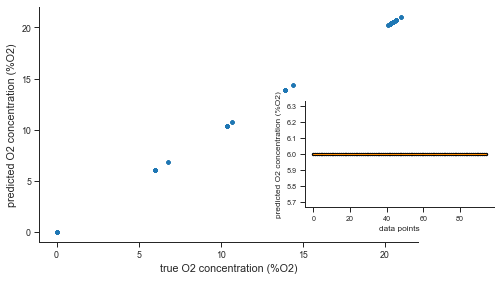

In [239]:
ox_insert = 6
fig, ax = plt.subplots(figsize=(6,4))
ax2 = plt.axes([0, 0, 1, 1])

ax.set_xlabel('true O2 concentration (%O2)', fontsize=fs*0.9), ax.set_ylabel('predicted O2 concentration (%O2)', fontsize=fs*0.9)

ax2.set_xlabel('data points', fontsize=fs*0.7), ax2.set_ylabel('predicted O2 concentration (%O2)', fontsize=fs*0.7)
ax2.tick_params(labelsize=fs*0.6)

ax.plot(df_ox_train, lw=0, marker='.')
# ax.set_xlim(0, 14), ax.set_ylim(0, 14)

# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.7,0.15,0.5,0.45])
ax2.set_axes_locator(ip)
ax2.plot([round(o, 1) for o in df_ox_train.loc[ox_insert, 'training O2 - predict'].to_numpy()], lw=0, marker='.', color='k')
ax2.plot([round(o, 1) for o in df_ox_train.loc[ox_insert,].index], lw=1, color='darkorange')

sns.despine(), plt.tight_layout()

# ---------------------------------------------------------------------
# save figure
# fig.savefig('20221005_crossCheck_O2_training.png', dpi=300, transparent=True)

<ipython-input-241-87c3f79a333f>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  sns.despine(), plt.tight_layout()


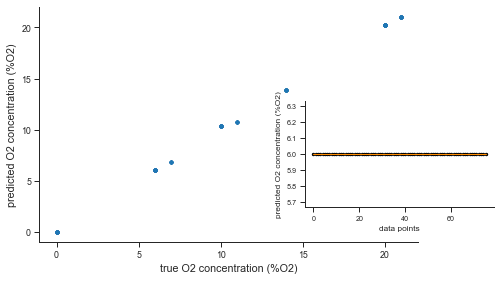

In [241]:
ox_insert = 6
fig, ax = plt.subplots(figsize=(6,4))
ax2 = plt.axes([0, 0, 1, 1])

ax.set_xlabel('true O2 concentration (%O2)', fontsize=fs*0.9), ax.set_ylabel('predicted O2 concentration (%O2)', fontsize=fs*0.9)

ax2.set_xlabel('data points', fontsize=fs*0.7), ax2.set_ylabel('predicted O2 concentration (%O2)', fontsize=fs*0.7)
ax2.tick_params(labelsize=fs*0.6)

ax.plot(df_ox_valid, lw=0, marker='.')
# ax.set_xlim(0, 14), ax.set_ylim(0, 14)

# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax, [0.7,0.15,0.5,0.45])
ax2.set_axes_locator(ip)
ax2.plot([round(o, 1) for o in df_ox_valid.loc[ox_insert, 'validation O2 - predict'].to_numpy()], lw=0, marker='.', color='k')
ax2.plot([round(o, 1) for o in df_ox_valid.loc[ox_insert,].index], lw=1, color='darkorange')

sns.despine(), plt.tight_layout()

# ---------------------------------------------------------------------
# save figure
# fig.savefig('20221005_crossCheck_O2_validation.png', dpi=300, transparent=True)

# Cross-validation

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [242]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

n_splits = 10

In [246]:
# k-fold cross-validation of the pH prediction
X_train_ph = X_train_l1.copy()
X_train_ph.columns = np.arange(X_train_ph.shape[1])
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)

scores_ph = cross_val_score(reg_xgb_l1, X_train_cv, y_target_l1, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mae_ph, rmse_ph = np.mean(np.absolute(scores_ph)), np.sqrt(np.mean(np.absolute(scores_ph)))
print('scores for pH: \nmae: {:.2e} \t rmse: {:.2e}'.format(mae_ph, rmse_ph))

scores for pH: 
mae: 3.60e-01 	 rmse: 6.00e-01


In [247]:
# k-fold cross-validation of the O2 prediction
X_train_ox = X_train_l3.copy()
X_train_ox.columns = np.arange(X_train_ox.shape[1])

cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
scores = cross_val_score(reg_xgb_l2, X_train_l3, y_target_l3, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mae, rmse = np.mean(np.absolute(scores)), np.sqrt(np.mean(np.absolute(scores)))

print('scores for O2: \nmae: {:.2e} \t rmse: {:.2e}'.format(mae, rmse))

scores for O2: 
mae: 1.56e-05 	 rmse: 3.95e-03
